### AIM: determine whether an ML algorithm can predict a galaxy group's M200 given the galaxy's (pre-calculated) $\Sigma_M$, $\Sigma_5$, Mstar, and group Ngal.

#### Training M200 values are taken from Tempel+2017's group catalog, as are environment flags

#### $\Sigma_M$ and $\Sigma_5$ are both density-related parameters to characterize a galaxy's local environment and are calculated using my own algorithms found in `../wisesize/environment_classifications`

#### Mstar is from the NED-LVS catalog (Cook+21)

In [1]:
#load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from astropy.table import Table
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from M200_functions import *

import os
homedir=os.getenv('HOME')

In [2]:
try:
    df = pd.read_csv(homedir+'/Desktop/ML_features.csv')
    print('Skip the "Generate..." tab below.')
except:
    print('You will have to run all of the Sigma_* variants again...have a time!')
    print('Open the "Generate..." tab below to continue.')

Skip the "Generate..." tab below.


#### Generate a few $\Sigma_k$ and $\Sigma_{M}$ (and Ngal) columns for testing

In [2]:
#create list of parameters which will be inputted into some fun little function wrappers
#which run my density scripts. these parameter represent the bounds within which the density
#will be calculated for each central galaxy

#vr_limit in km/s, radius_limit in Mpc

vr_limits_M = [1000,1500,1500,500,600,1000,1000,1000,1000,1000,1000,300,300,2000,300,1000]
radius_limits = [1.5,1.5,1.0,1.0,1.0,0.1,0.75,0.5,1.0,2.0,3.0,1.5,0.25,2.0,1.0,3.0]
vr_limits_k = [1000,1000,1000,1000,1000]
k_list = [2,3,5,10,20]

In [3]:
#get list of Sigma_M and Sigma_Ngal features along with a corresponding list of column names (for later)
SigmaM_features, SigmaM_names = generate_SigmaM_variants(vr_limits_M, radius_limits)

Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 1.5


/Users/k215c316/github/wisesize/environment_classifications/mstar_local_density.py:186: UserWarning: Warning: converting a masked element to nan.
  all_Sigma_Mstar[n] = galaxy.density_Mstar


Number of galaxies with no Sigma_M: 0
Finished in 2.29 minutes


Calculating Sigma_M and Ngal for vr_limit = 1500 and radius_limit = 1.5
Number of galaxies with no Sigma_M: 0
Finished in 2.21 minutes
Calculating Sigma_M and Ngal for vr_limit = 1500 and radius_limit = 1.0
Number of galaxies with no Sigma_M: 0
Finished in 2.22 minutes
Calculating Sigma_M and Ngal for vr_limit = 500 and radius_limit = 1.0
Number of galaxies with no Sigma_M: 0
Finished in 2.22 minutes
Calculating Sigma_M and Ngal for vr_limit = 600 and radius_limit = 1.0
Number of galaxies with no Sigma_M: 0
Finished in 2.24 minutes
Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 0.1
Number of galaxies with no Sigma_M: 0
Finished in 2.20 minutes
Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 0.75
Number of galaxies with no Sigma_M: 0
Finished in 2.25 minutes
Calculating Sigma_M and Ngal for vr_limit = 1000 and radius_limit = 0.5
Number of galaxies with no Sigma_M: 0
Finished in 2.21 minutes
Calculating Sigma_M and Ngal for vr_limit = 1000 and rad

In [5]:
#get list of Sigma_k features along with a corresponding list of column names (for later)
Sigmak_features, Sigmak_names = calculate_Sigmak_variants(vr_limits_k, k_list)

Running kNN density calculation with k=2, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.


/Users/k215c316/github/wisesize/environment_classifications/kNN_local_density.py:194: RuntimeWarning: divide by zero encountered in scalar divide
  self.density_kSigma = self.k / (np.pi * r_k**2)


# galaxies with no valid kNN: 0
Finished in 2.86 minutes
Running kNN density calculation with k=3, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.86 minutes
Running kNN density calculation with k=5, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.86 minutes
Running kNN density calculation with k=10, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.85 minutes
Running kNN density calculation with k=20, vr_limit=1000, radius_limit=100
NED-LVS catalog selected with 26193 galaxies after applying flags.
# galaxies with no valid kNN: 0
Finished in 2.86 minutes


In [2]:
#load tables
#note -- each catalog has already been matched with WISESize (with 10" error)
path = homedir+'/Desktop/wisesize/'
nedlvs_parent = Table.read(path+'nedlvs_parent_v1.fits')
main_nedlvs = Table.read(path+'/archive_tables/NEDLVS_20210922_v2.fits')

nedlvs_parent['Mstar']=np.log10(main_nedlvs['Mstar'])
#nedlvs_parent['SFR_hybrid']=np.log10(main_nedlvs['SFR_hybrid'])
#nedlvs_parent['Lum_W1']=np.log10(main_nedlvs['Lum_W1'])
#nedlvs_parent['Lum_W3']=np.log10(main_nedlvs['Lum_W3'])
#nedlvs_parent['Lum_NUV']=np.log10(main_nedlvs['Lum_NUV'])

#these flags will be important later on when creating the ML models!

#WISESize sample flag
wisesize_flag = nedlvs_parent['WISESize_flag']

#want to only isolate Tempel+2017 galaxies. None of the non-Tempel galaxies!
tempel_flag = (nedlvs_parent['tempel2017_flag'])  

#flag to isolate Tempel+2017 groups
group_flag = (nedlvs_parent['tempel2017_groupIDs']>0)

In [4]:
#row match the columns to parent galaxy catalog!
nedlvs_parent = rowmatch_to_catalog(nedlvs_parent, SigmaM_features, SigmaM_names, Sigmak_features, Sigmak_names)

#### Principal Component Analysis -- Feature Optimization
##### (Trim parent galaxy catalog, convert to a Pandas Dataframe, etc.)

In [6]:
#let's first create our dataframe

#apply the trimming flags we discussed earlier!
#note: we will isolate Tempel+2017 group galaxies later on, in particular for where we use halo mass
nedlvs_parent_test = nedlvs_parent[tempel_flag & wisesize_flag]

In [7]:
#and then...
df = nedlvs_parent_test.to_pandas()

#slight detour - convert M200 to log(M200)
df['group_M200'] = np.log10(df['group_M200'])

/Users/k215c316/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
#replace -999 with NaNs
df.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df = df.dropna()

In [9]:
#and that is that.

In [14]:
#prepare the FEATURE NAMES/COLUMNS!
feature_names = SigmaM_names+Sigmak_names

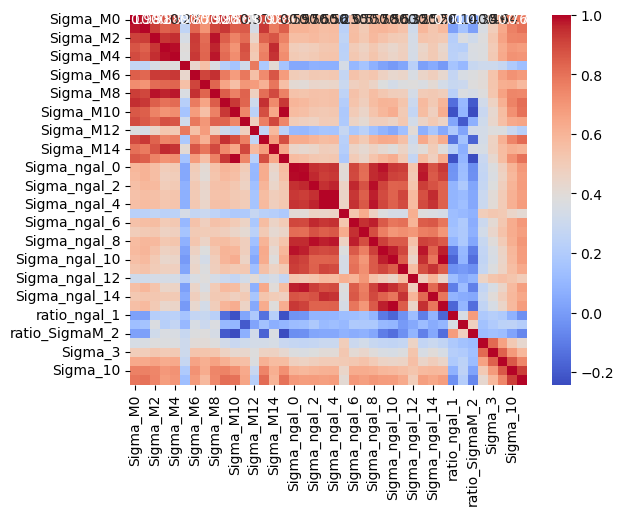

In [15]:
#Assume that we have this massive list of features, which we generated above. 
#We want to determine which features are HIGHLY correlated, and in so doing combine then into one
#composite feature so as to reduce complexity without surrendering model robustness

#maybe your feature list looks like the following:
features = df[feature_names]

#and you want to find the correlations:
find_correlations(features)

In [16]:
#the plot above displays a grid which maps the strength of correlations between features
#say you know which features you would like to merge into one single feature

correlated_groups = {
    'SigmaM1M2M3M7': ['Sigma_M1', 'Sigma_M2', 'Sigma_M3', 'Sigma_M7'],
    'SigmaM9M10': ['Sigma_M9', 'Sigma_M10'],
    'SigmaM11M12': ['Sigma_M11', 'Sigma_M12'],
    'Sigma10_20': ['Sigma_10', 'Sigma_20'],
    'SigmaNgal': ['Sigma_ngal_6', 'Sigma_ngal_11']
}

In [17]:
#the resulting dataframe contains these PCA features (labeled as such with a "_pca" suffix).
#each singular parameter listed in the correlated_groups dictionary is removed, so don't go
#seaching for them.

df_out = perform_pca(df, correlated_groups, n_components=1)

#### Random Forest Regression
##### Using Tempel+2017 groups and M200
##### Best result (all log(M200)): MSE = 0.663 | R² = 0.553 (split random_state = 63; test_size=0.15)
##### Best result (log(M200)>12): MSE = 0.110 | R² = 0.699 (split random_state = 27; test_size=0.3)

In [18]:
#note: using halo mass, so must isolate Tempel+2017 group galaxies (which actually have a halo mass)
df_group = df_out[df_out['tempel2017_groupIDs']>0]

In [19]:
#replace -999 with NaNs, in case there are any lingering buggers
df_group.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df_group = df_out.dropna()

In [48]:
#predictors...some hodgepodge of potentially relevant properties.
X =df_group[['Sigma_5', 'Sigma_M4', 'SigmaM11M12_pca', 'Sigma_M13', 'Sigma_M14', 
    'Sigma_M15', 'Sigma_ngal_12', 'ratio_SigmaM_1', 'ratio_SigmaM_2', 'ratio_ngal_1', 
    'SigmaM1M2M3M7_pca', 'Sigma10_20_pca', 'SigmaNgal_pca']]

#target variable...log(M200)
y = df_group['group_M200']

In [39]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=63)

In [40]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [41]:
y_pred = model.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


MSE: 0.663
R²: 0.553


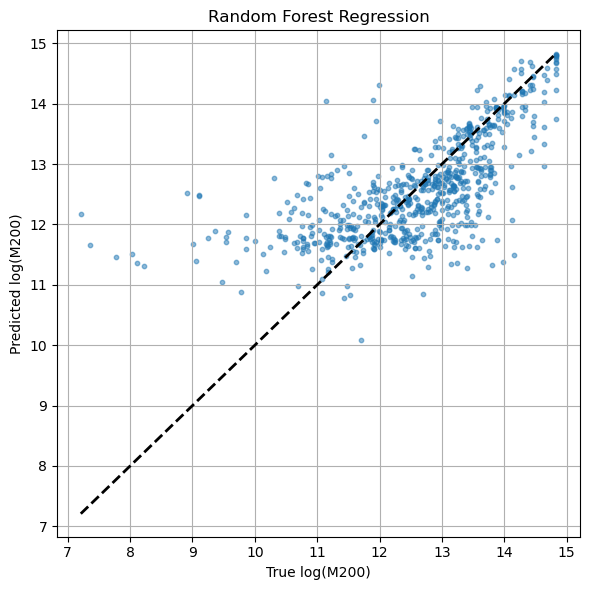

In [38]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True log(M200)")
plt.ylabel("Predicted log(M200)")
plt.title("Random Forest Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

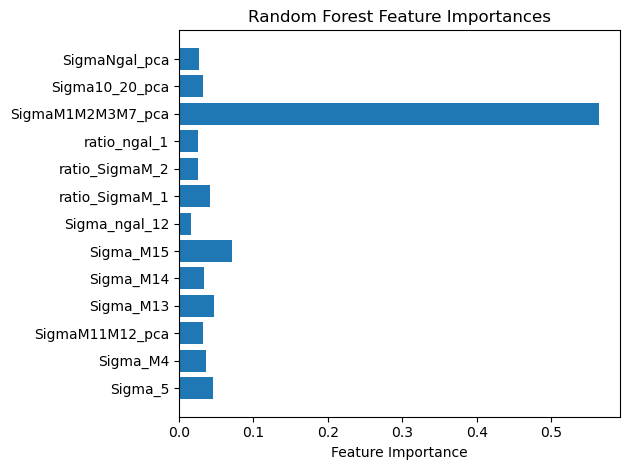

In [43]:
#Adding redundant features can reduce generalization power.
#use this tool to identify such features, if any.

importances = model.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

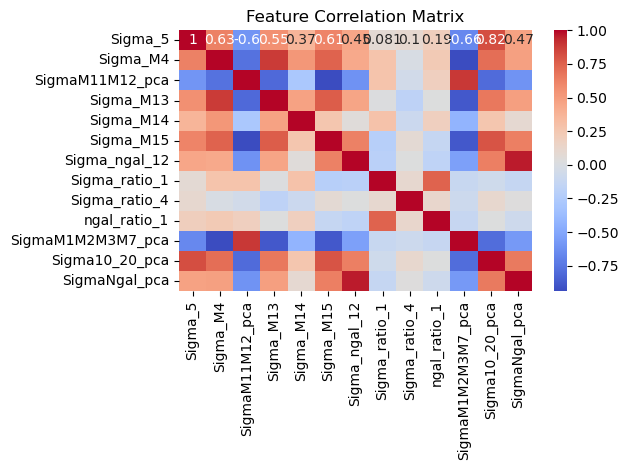

In [171]:
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

- Regression failing due to heteroscedasticity, measurement noise, or outliers (i.e., low-mass systems are all mapped to a floor).

- Prediction collapse around log(M200) ≈ 12 — suggesting the model is defaulting to the mean or median because it can't resolve differences.

#### Random Forest M200 Classification (Tempel+2017 groups and M200)
##### 0 = [12.5<M200], 1 = [12.5<M200<14.],  2 = [M200>14.]
##### Best result: 78.00% accuracy 

In [44]:
#note: using halo mass, so must isolate Tempel+2017 group galaxies (which actually have a halo mass)
df_group = df_out[df_out['tempel2017_groupIDs']>0]

In [45]:
#replace -999 with NaNs, in case there are any lingering buggers
df_group.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df_group = df_out.dropna()

In [46]:
#M200 bins
bin1 = df_group['group_M200'] < 12.5
bin2 = (df_group['group_M200'] >= 12.5) & (df['group_M200'] < 14.)
bin3 = (df_group['group_M200'] >= 14.)

df_group.loc[:, 'env_class'] = np.select([bin1, bin2, bin3], [0, 1, 2])

In [47]:
#check whether number of galaxies in each "bin" is relatively balanced
print(df_group['env_class'].value_counts())

env_class
1    2231
0    2002
2     516
Name: count, dtype: int64


In [49]:
X =df_group[['Sigma_5', 'Sigma_M4', 'SigmaM11M12_pca', 'Sigma_M13', 'Sigma_M14', 
    'Sigma_M15', 'Sigma_ngal_12', 'ratio_SigmaM_1', 'ratio_SigmaM_2', 'ratio_ngal_1', 
    'SigmaM1M2M3M7_pca', 'Sigma10_20_pca', 'SigmaNgal_pca']]


y = df_group['env_class']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
model = RandomForestClassifier(
    n_estimators=80,
    max_depth=14,
    class_weight='balanced',
    random_state=42,
    max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=80,
                       random_state=42)

In [52]:
y_pred = model.predict(X_test)

In [53]:
accuracy = (np.sum(np.diag(confusion_matrix(y_test, y_pred)))) / (np.sum(confusion_matrix(y_test, y_pred))) 
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 77.37%


In [54]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.740     0.818     0.777       401
           1      0.792     0.726     0.758       446
           2      0.847     0.806     0.826       103

    accuracy                          0.774       950
   macro avg      0.793     0.783     0.787       950
weighted avg      0.776     0.774     0.773       950



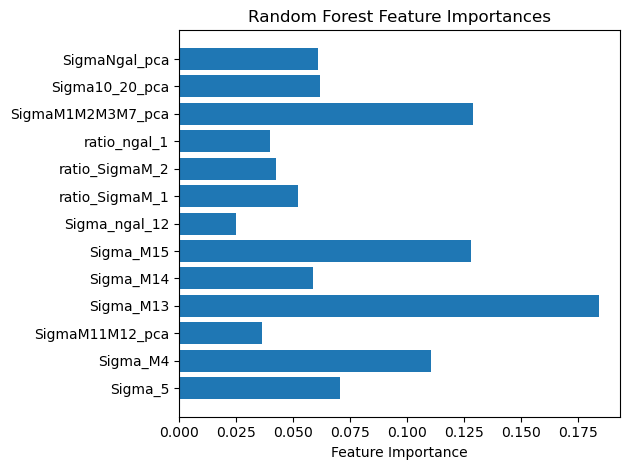

In [55]:
importances = model.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [56]:
for n in range(len(features)):
    print(f'{features[n]}: {importances[n]:.4f}')

Sigma_5: 0.0708
Sigma_M4: 0.1107
SigmaM11M12_pca: 0.0364
Sigma_M13: 0.1841
Sigma_M14: 0.0588
Sigma_M15: 0.1281
Sigma_ngal_12: 0.0250
ratio_SigmaM_1: 0.0521
ratio_SigmaM_2: 0.0425
ratio_ngal_1: 0.0401
SigmaM1M2M3M7_pca: 0.1288
Sigma10_20_pca: 0.0618
SigmaNgal_pca: 0.0609


<Axes: >

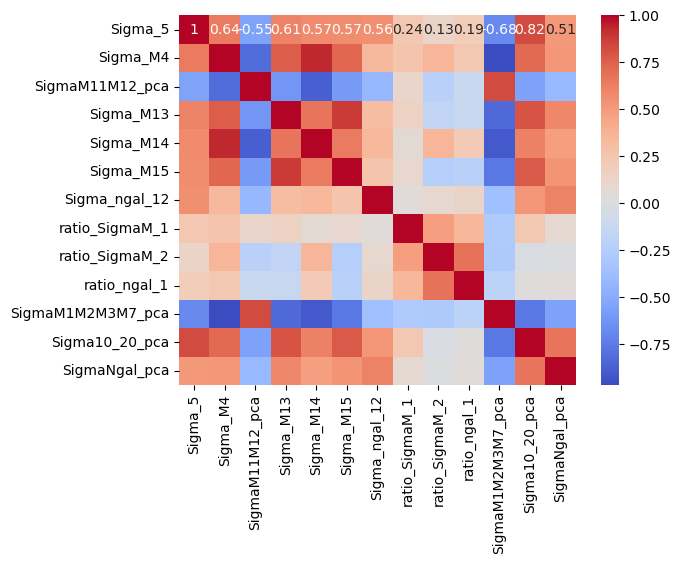

In [57]:
#CORRELATION MAP! Check if there are any redundant features (correlation > 0.95 or so)

import seaborn as sns
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

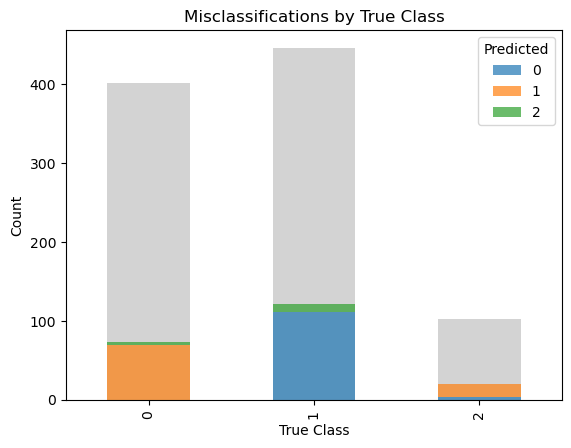

In [58]:
plot_misclassifications(y_test, y_pred)

In [59]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5)
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy', n_jobs=1)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected features:", list(X_train.columns[rfecv.support_]))

Optimal number of features: 11
Selected features: ['Sigma_5', 'Sigma_M4', 'Sigma_M13', 'Sigma_M14', 'Sigma_M15', 'ratio_SigmaM_1', 'ratio_SigmaM_2', 'ratio_ngal_1', 'SigmaM1M2M3M7_pca', 'Sigma10_20_pca', 'SigmaNgal_pca']


In [60]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

selected_features = list(X_train.columns[rfecv.support_])

X_selected = X[selected_features]

# Define the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Define the cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# Evaluate model using cross-validation
scores = cross_val_score(rf_model, X_selected, y, scoring='accuracy', cv=cv, n_jobs=1)

# Report performance
print(f"Mean Accuracy: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores)}")

Mean Accuracy: 0.7743
Standard Deviation: 0.012415896152810054


#### Random Forest Environment Classification (Tempel+2017 environment flags)
##### 0 = field, 1 = group/cluster
##### Best result: 78.49% accuracy
----
##### 0 = field, 1 = group, 2 = cluster
##### Best result: 75.51% accuracy

In [195]:
#replace -999 with NaNs
df_out.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df_out = df_out.dropna()

In [196]:
#just creating 0, 1, 2 classes based on Tempel flags --> 0 field, 1 group, 2 cluster

#df_out['env_class'] = np.select([df_out['tempel_field_flag'],
#                                 df_out['tempel2017_group_flag'], df['tempel2017_cluster_flag']],
#                [0, 1, 2])

df_out['env_class'] = np.select([df_out['tempel_field_flag'],
                                 df_out['tempel2017_group_flag'],df_out['tempel2017_cluster_flag']],
                [0, 1, 2])

In [197]:
X = df_out[['Sigma_5', 'Sigma_M4', 'SigmaM11M12_pca', 'Sigma_M13', 'Sigma_M14', 
    'Sigma_M15', 'Sigma_ngal_12', 'Sigma_ratio_1', 'Sigma_ratio_4', 'ngal_ratio_1', 
    'SigmaM1M2M3M7_pca', 'Sigma10_20_pca', 'SigmaNgal_pca']]

#target variable...environment *class*
y = df_out['env_class']  

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [199]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=80, max_depth=14)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=80,
                       random_state=42)

In [200]:
y_pred = clf.predict(X_test)

In [201]:
accuracy = (np.sum(np.diag(confusion_matrix(y_test, y_pred)))) / (np.sum(confusion_matrix(y_test, y_pred))) 
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 96.63%


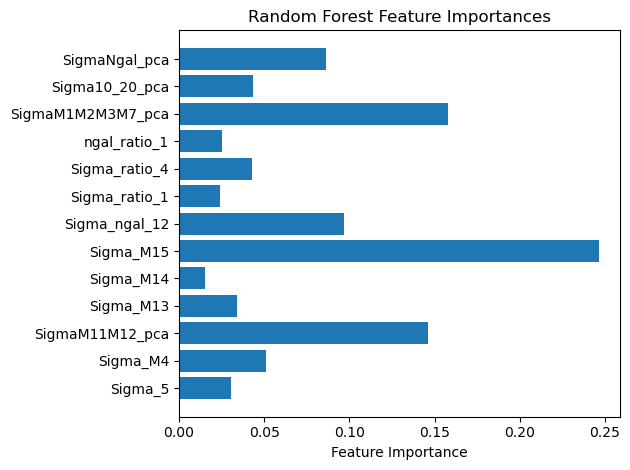

In [202]:
importances = clf.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

<Axes: >

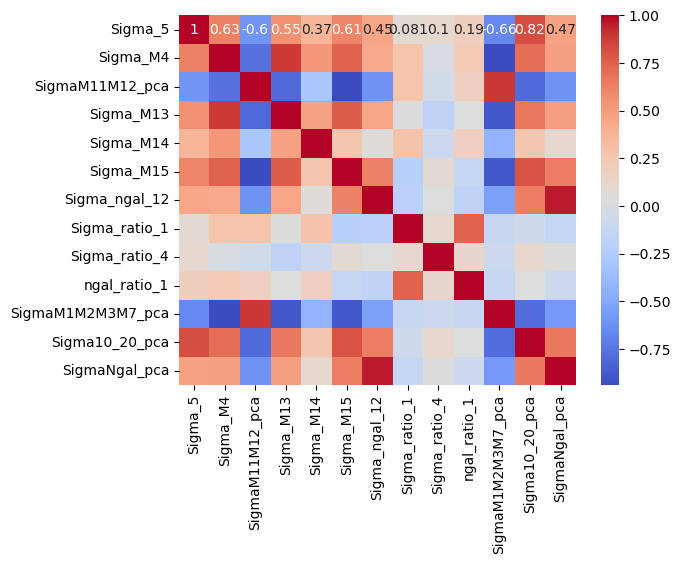

In [203]:
#CORRELATION MAP! Check if there are any redundant features (correlation > 0.95 or so)

import seaborn as sns
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

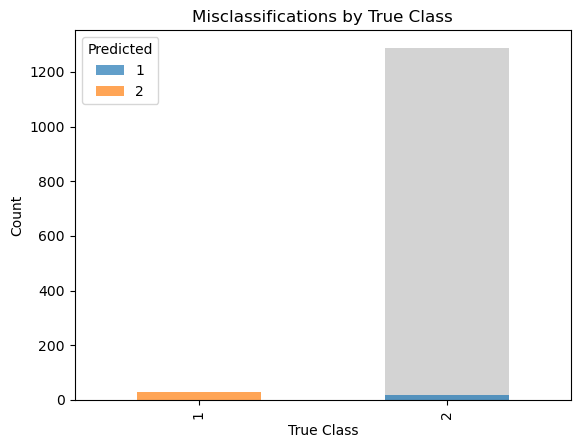

In [204]:
plot_misclassifications(y_test, y_pred)